# Clustering

### Description

- Cluster funds using k-means

In [494]:
import feather
import numpy as np
import datetime
import pandas as pd
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

## Setup

In [495]:
# Convert to date format
begin_date = '2017-01-01'
end_date   = '2017-12-31'

In [496]:
begin_date = datetime.date.fromisoformat('2017-01-01')
end_date = datetime.date.fromisoformat('2017-12-31')

## Load Data

### Returns

In [497]:
path = '../data/processed/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

(5208008, 4)

In [498]:
returns.dtypes

crsp_fundno           float64
caldt                  object
mret                  float64
date           datetime64[ns]
dtype: object

In [499]:
# Filter based on date
returns = returns.query('caldt >= @begin_date & caldt <= @end_date')
returns.shape

(396112, 4)

### Summary

In [500]:
path = '../data/processed/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(163848, 9)

### Holdings

In [501]:
path = '../data/processed/holdings_b.npz'
holdings = sparse.load_npz(path)
holdings.shape

(163848, 13442)

In [502]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(163848, 9)
Shape of holding information
(163848, 13442)


## Take only one Observation per year and fund and for the spezified timeframe

In [503]:
t.year

2003

In [504]:
summary = summary.reset_index(drop = True)

index = (summary
     .assign(year = pd.to_datetime(summary["report_dt"]).dt.year)
     .groupby(['port_no','year'])
     [['port_no','report_dt']]
     .tail(1)
     .query('report_dt >= @begin_date and report_dt <= @end_date')
     .index)

summary = summary.loc[index]
holdings = holdings[index.values]

In [505]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(2370, 9)
Shape of holding information
(2370, 13442)


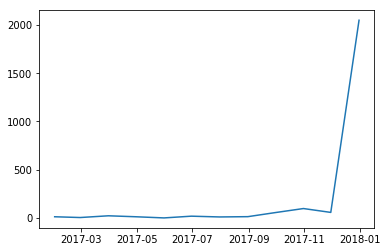

In [506]:
plt.plot(summary.groupby('report_dt').count()['port_no'])

## Merge Lipper_class onto returns data

### Merge does not take dates into account -> TODO

In [507]:
summary.dtypes

port_no           int64
report_dt        object
fund_name        object
avrcs           float64
lipper_class     object
False            object
cap_class        object
style_class      object
fund_no           int64
dtype: object

In [508]:
returns.head(1)

,crsp_fundno,caldt,mret,date
233,105.0,2017-01-31,0.028147,2017-01-31


In [509]:
returns_merged = returns.merge(summary, how='left', left_on=['crsp_fundno'],right_on=['fund_no'])
returns_merged.shape

(396112, 13)

In [510]:
returns_merged = returns_merged.drop(columns=['report_dt','fund_no'])

In [511]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(27103, 11)

#### Take only needed columns and reorder them

In [512]:
returns_merged = returns_merged[['port_no','caldt','mret','lipper_class','style_class','cap_class']]

In [513]:
returns_merged.sample()

,port_no,caldt,mret,lipper_class,style_class,cap_class
147791,1028313.0,2017-10-31,0.026964,MCCE,C,M


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [514]:
group_by = 'lipper_class'

In [515]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values
obj_codes

array(['SCCE', 'LCGE', 'LCVE', 'SCGE', 'MCVE', 'LCCE', 'MLVE', 'MLGE',
       'MCCE', 'MLCE', 'SCVE', 'MCGE'], dtype=object)

In [516]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [517]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [518]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [519]:
returns_obj_n = returns_obj.pivot_table(
        values='std', 
        index=['caldt'], 
        columns=group_by)

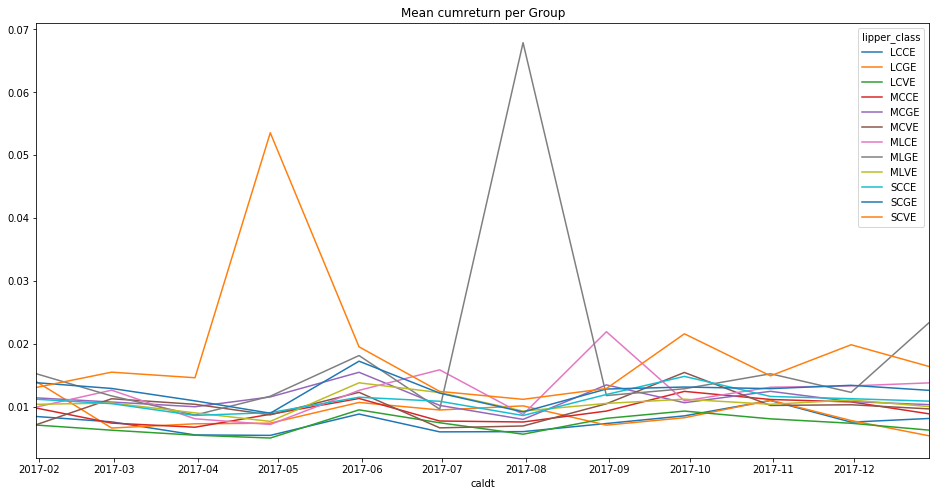

In [520]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [521]:
holdings.shape

(2370, 13442)

In [522]:
mask_columns = pd.Series(np.squeeze(np.array(holdings.sum(0))) > 10)
mask_rows = pd.Series(np.squeeze(np.array(holdings.sum(1))) > 10)

In [523]:
print(mask_rows.shape,mask_columns.shape)

(2370,) (13442,)


In [524]:
holdings = holdings[:,mask_columns.values]
holdings = holdings[mask_rows.values,:]
summary = summary[mask_rows.values]
holdings.shape

(2310, 3426)

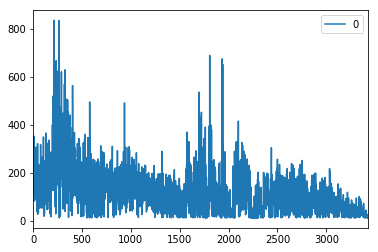

In [525]:
# Sum per stock
pd.DataFrame(holdings.sum(0)).T.plot()

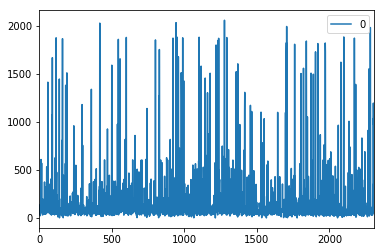

In [526]:
# Sum per fund
pd.DataFrame(holdings.sum(1)).plot()

In [527]:
clustering = SpectralClustering(n_clusters=4,
                                assign_labels='discretize',
                                eigen_solver='amg',
                                n_jobs= -1,
                                random_state=0).fit(holdings)

In [528]:
clustering.labels_

array([0, 0, 0, ..., 3, 0, 0])

In [568]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 4,
                verbose = True,
                n_init = 5, # Number of runs
                n_jobs= -1,
                random_state=123).fit(holdings)

Start kMeans...


In [570]:
labels = pd.DataFrame(clustering.labels_)
labels = pd.DataFrame(kmeans.labels_)

In [571]:
summary['cluster'] = labels.values

In [572]:
summary.loc[summary.cluster == 2,['fund_name']].values

array([['AIM Sector Funds (Invesco Sector Funds): Invesco Comstock Fund; Class A Shares'],
       ['Neuberger Berman Equity Funds: Neuberger Berman Large Cap Value Fund; Trust Class'],
       ['AIM Sector Funds (Invesco Sector Funds): Invesco American Value Fund; Class Y Shares'],
       ...,
       ['Financial Investors Trust: Emerald Insights Fund; Institutional Class Shares'],
       ['Forum Funds II: Acuitas US Microcap Fund; Institutional Class Shares'],
       ['Northern Lights Fund Trust III: HCM Tactical Growth Fund; Class A Shares']],
      dtype=object)

In [573]:
round(pd.crosstab(summary['cap_class'],summary['cluster'], margins = True, normalize = 'all') * 100, 2)

cluster,0,1,2,3,All
cap_class,,,,,
L,2.34,0.04,28.79,0.00,31.17
M,2.81,1.30,36.06,0.35,40.52
S,0.00,5.19,20.74,2.38,28.31
All,5.15,6.54,85.58,2.73,100.00


In [574]:
round(pd.crosstab(summary['style_class'],summary['cluster'], margins = True, normalize = 'all') * 100, 2)

cluster,0,1,2,3,All
style_class,,,,,
C,3.46,4.37,35.76,2.29,45.89
G,0.87,1.26,31.90,0.17,34.20
V,0.82,0.91,17.92,0.26,19.91
All,5.15,6.54,85.58,2.73,100.00


## Chart the returns of the formed clustes

In [558]:
summary.sample()

,level_0,index,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,cluster
1639,1639,122578,1027281,2017-12-31,VALIC Company I: Large Capital Growth Fund,95.415532,LCGE,LCGE,L,G,30882,0


#### Merge new clusters into returns

In [559]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
18149,2017-12-29,6752.0,1026924.0,0.005298,SCGE,3.0


#### Calc mean return per Obj_cd

In [560]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([3., 0., 2., 1.])

In [561]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [562]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

In [567]:
plt.plot(clustering.cluster_centers_[0,:])

AttributeError: 'SpectralClustering' object has no attribute 'cluster_centers_'

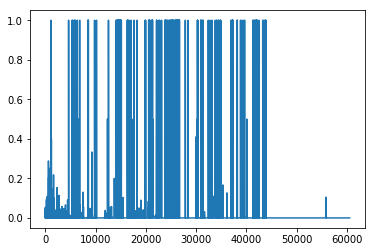

In [248]:
plt.plot(kmeans.cluster_centers_[1,:])

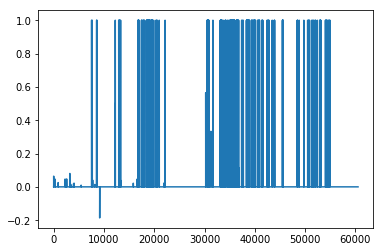

In [249]:
plt.plot(kmeans.cluster_centers_[2,:])

## PCA

In [ ]:
pca = PCA(n_components=10)
pca.fit(holdings.toarray())  

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
df = pd.DataFrame(pca.components_).T
df = pd.DataFrame({
    'pca_1' : df.iloc[:,0],
    'pca_2' : df.iloc[:,1],
    'labels' : labels.iloc[:,0]
})

In [ ]:
df.plot.scatter(x='pca_1',
                y='pca_2',
                c='labels',
                colormap='viridis')

# Visualize

In [ ]:
MiniBatchKMeans?

For n_clusters = 2 The average silhouette_score is : 0.6655655253020518
For n_clusters = 3 The average silhouette_score is : -0.11048678935719358
For n_clusters = 4 The average silhouette_score is : -0.11397895334543343
For n_clusters = 5 The average silhouette_score is : -0.1770654711818058


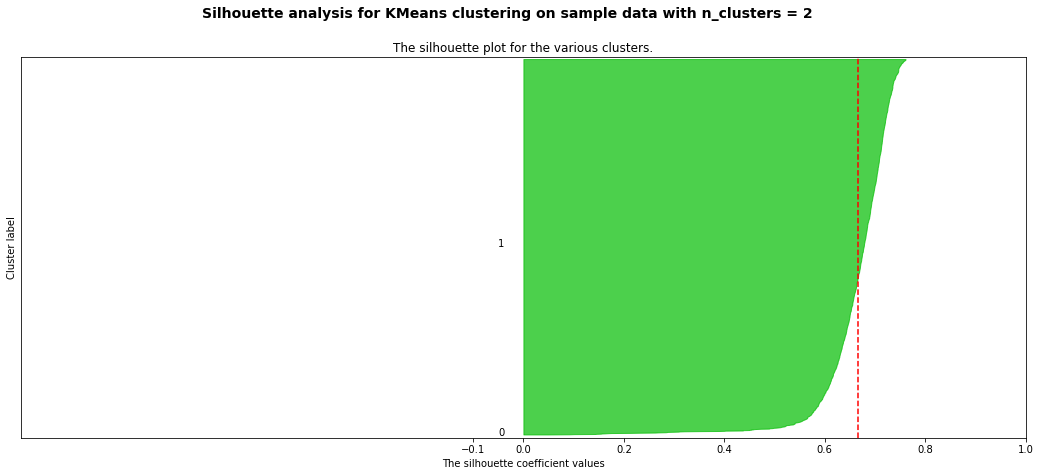

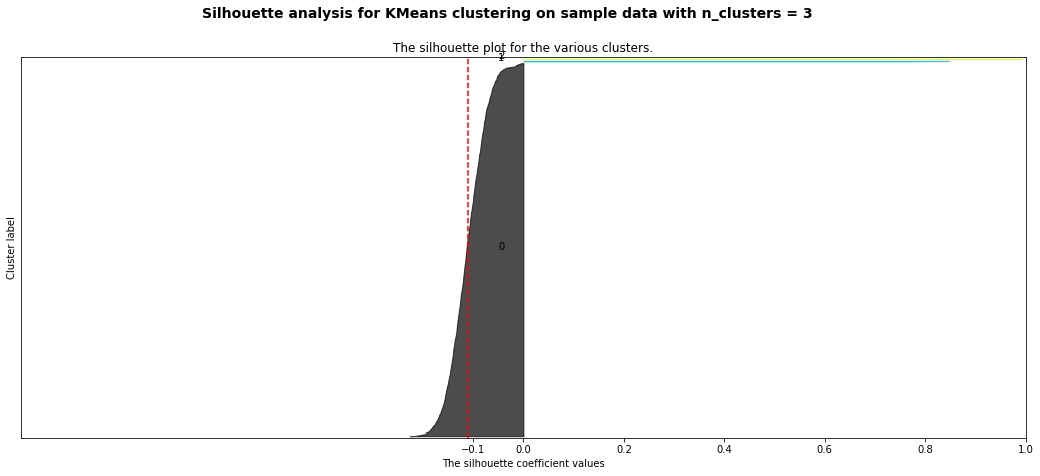

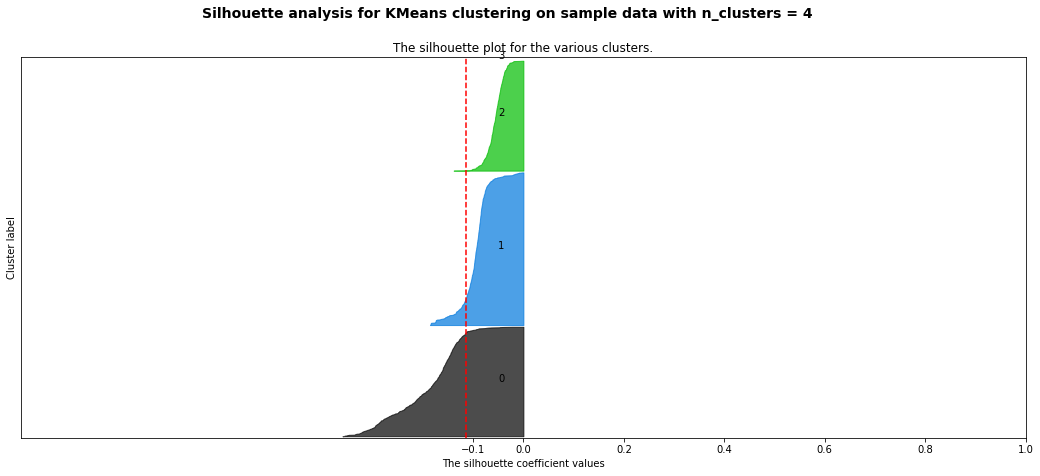

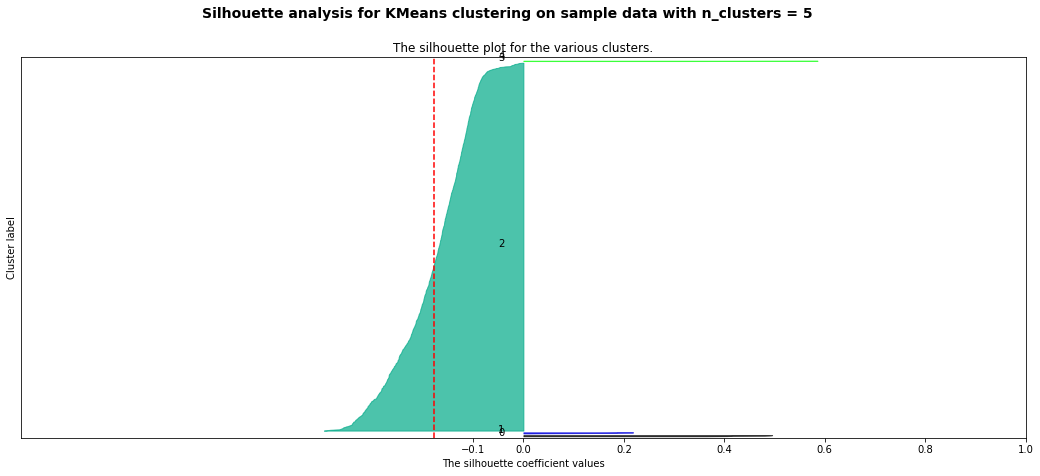

In [250]:
### Based on example code from sklearn ###

X = holdings
n_clusters = [2,3,4,5]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()